In [503]:
import numpy as np
import pandas as pd

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import scipy.stats as ss

sys.path.append('../../src/')
import toolbox

In [504]:
r = requests.get('http://data.thecrix.de/data/crix11.json').json()
VCRIX = pd.DataFrame(r)
VCRIX.date = pd.to_datetime(VCRIX.date)

# VCRIX.n = VCRIX.n.astype(np.int)

_id = VCRIX.date > '20180614'

VCRIX = VCRIX.loc[_id, :]

VCRIX.n = list(range(len(VCRIX)))

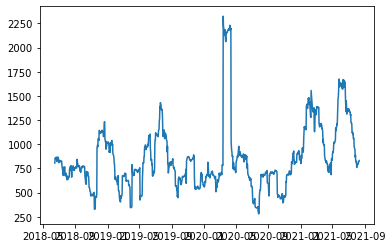

In [505]:
plt.plot(VCRIX.date, VCRIX.vcrix)

# thres = np.quantile(VCRIX.vcrix , 0.90)

thres = 1000
i = VCRIX.vcrix >=thres
# plt.scatter(VCRIX.date.loc[i], VCRIX.vcrix.loc[i], color='red')

stress_period = VCRIX.loc[i, :]

# for i in range(len(stress_period)-1):
#     start = training_Clayton.Date.iloc[i]
#     end =  training_Clayton.Date.iloc[i+1]
#     _end = end
#     plt.axvspan(start, end,facecolor='black', alpha=.2)

In [506]:
stress_period.date

1459   2018-11-26
1460   2018-11-27
1461   2018-11-28
1462   2018-11-29
1463   2018-11-30
          ...    
2424   2021-07-18
2425   2021-07-19
2426   2021-07-20
2427   2021-07-21
2428   2021-07-22
Name: date, Length: 283, dtype: datetime64[ns]

In [507]:
last_n = stress_period.iloc[0,:].n

start_arr = [stress_period.iloc[0,:].date]
end_arr = []

for row_i in range(1, len(stress_period)-2):
    
    last_n = stress_period.iloc[row_i-1,:].n
    n  = stress_period.iloc[row_i,:].n
    next_n = stress_period.iloc[row_i+1,:].n
    next_next_n = stress_period.iloc[row_i+2,:].n

    
    if (next_n-n>1):
        end_arr.append(stress_period.iloc[row_i,:].date)

    if n-last_n>1:
        start_arr.append(stress_period.iloc[row_i,:].date)

        
end_arr.append(stress_period.iloc[-1,:].date)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


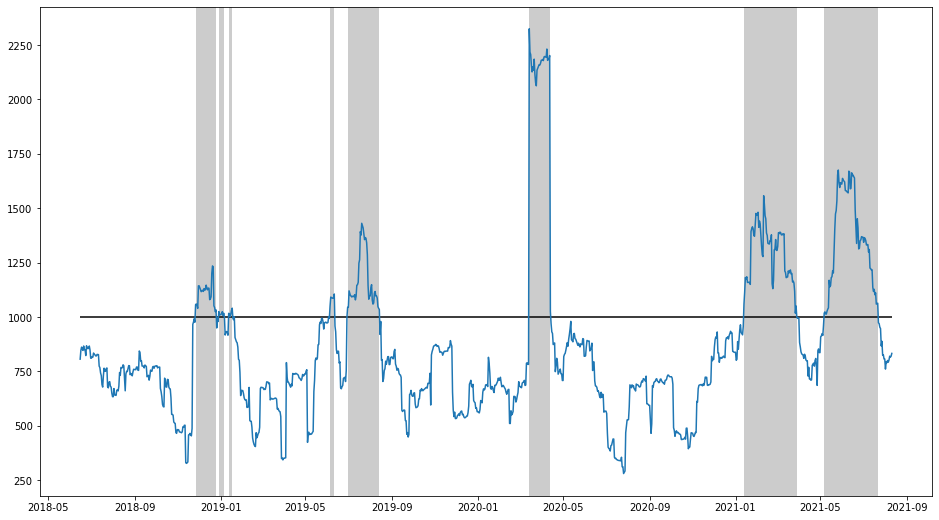

In [508]:
plt.figure(figsize=(16,9))
plt.plot(VCRIX.date, VCRIX.vcrix)

plt.hlines(y=thres, xmin=VCRIX.iloc[0,:].date, xmax=VCRIX.iloc[-1,:].date)


# plt.plot(stress_period.date, stress_period.vcrix)
for i in range(len(start_arr)):
    start = start_arr[i]
    end =  end_arr[i]
    plt.axvspan(start, end, facecolor='black', alpha=.2)

In [509]:
np.array(end_arr)  - np.array(start_arr) 

array([Timedelta('29 days 00:00:00'), Timedelta('7 days 00:00:00'),
       Timedelta('5 days 00:00:00'), Timedelta('0 days 00:00:00'),
       Timedelta('0 days 00:00:00'), Timedelta('6 days 00:00:00'),
       Timedelta('45 days 00:00:00'), Timedelta('30 days 00:00:00'),
       Timedelta('75 days 00:00:00'), Timedelta('76 days 00:00:00')],
      dtype=object)

In [510]:
for i in range(len(start_arr)):
    print(start_arr[i], end_arr[i])

2018-11-26 00:00:00 2018-12-25 00:00:00
2018-12-29 00:00:00 2019-01-05 00:00:00
2019-01-12 00:00:00 2019-01-17 00:00:00
2019-01-20 00:00:00 2019-01-20 00:00:00
2019-06-03 00:00:00 2019-06-03 00:00:00
2019-06-05 00:00:00 2019-06-11 00:00:00
2019-06-30 00:00:00 2019-08-14 00:00:00
2020-03-14 00:00:00 2020-04-13 00:00:00
2021-01-13 00:00:00 2021-03-29 00:00:00
2021-05-07 00:00:00 2021-07-22 00:00:00


In [544]:
result_names = ['BBT_Tiingo',
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',
                'BBT_future_BITX',
                'BBT_future_BITW20', 
                'BBT_future_BITW70', 
                'BBT_future_BITW100', 
                'BBT_future_CRIX']

# result_names = ['BBT_future_CRIX']

coin_names = ['bitcoin', 'ada', 'eth', 'ltc', 'xrp',
              'BITX', 'BITW20', 'BITW70', 'BITW100', 'CRIX']

i = 2
data_name = result_names[i]
coin_name = coin_names[i]
# objective = 'ERM k=10'
# objective = 'ES q=0.01'
objective = 'VaR q=0.01'

print(data_name, coin_name, objective)

rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, objective))

BBT_future_Tiingo_eth eth VaR q=0.01


In [545]:
rh_df.Date = pd.to_datetime(rh_df.Date.apply(lambda x: x[:10]))

In [546]:
s_id = rh_df.Date.apply(lambda x: x in list(stress_period.date))

In [547]:
train_path = '../../processed_data/%s/train/'%data_name
test_path = '../../processed_data/%s/test/'%data_name

files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

test_arr = []

for f in files:
    train = pd.read_csv(train_path+f)
    test = pd.read_csv(test_path+f)
    rs = train.iloc[:,-1]
    rf = train.iloc[:,-2]
    rho = np.corrcoef(rs,rf)[0,1]
    rs_std = np.std(rs)
    rf_std = np.std(rf)
    h = rho*rs_std/rf_std
    test.loc[:,'h_CH'] = h
    test_arr.append(test)
    
CH = pd.concat(test_arr)
CH.Date = pd.to_datetime(CH.Date)
CH = CH.sort_values('Date', ascending=False)

CH.reset_index(drop=True, inplace=True)
CH.loc[:,'rh'] = CH.loc[:,'log return %s'%coin_name] - CH.loc[:,'h_CH']* CH.loc[:,'log return future']

In [558]:
def create_CH(data_name, coin_name):
    train_path = '../../processed_data/%s/train/'%data_name
    test_path = '../../processed_data/%s/test/'%data_name

    files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

    test_arr = []

    for f in files:
        train = pd.read_csv(train_path+f)
        test = pd.read_csv(test_path+f)
        rs = train.iloc[:,-1]
        rf = train.iloc[:,-2]
        rho = np.corrcoef(rs,rf)[0,1]
        rs_std = np.std(rs)
        rf_std = np.std(rf)
        h = rho*rs_std/rf_std
        test.loc[:,'h_CH'] = h
        test_arr.append(test)

    CH = pd.concat(test_arr)
    CH.Date = pd.to_datetime(CH.Date)
    CH = CH.sort_values('Date', ascending=False)

    CH.reset_index(drop=True, inplace=True)
    CH.loc[:,'rh'] = CH.loc[:,'log return %s'%coin_name] - CH.loc[:,'h_CH']* CH.loc[:,'log return future']
    
    return CH

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

avg h 
copula     :0.967 
cross hedge:1.002


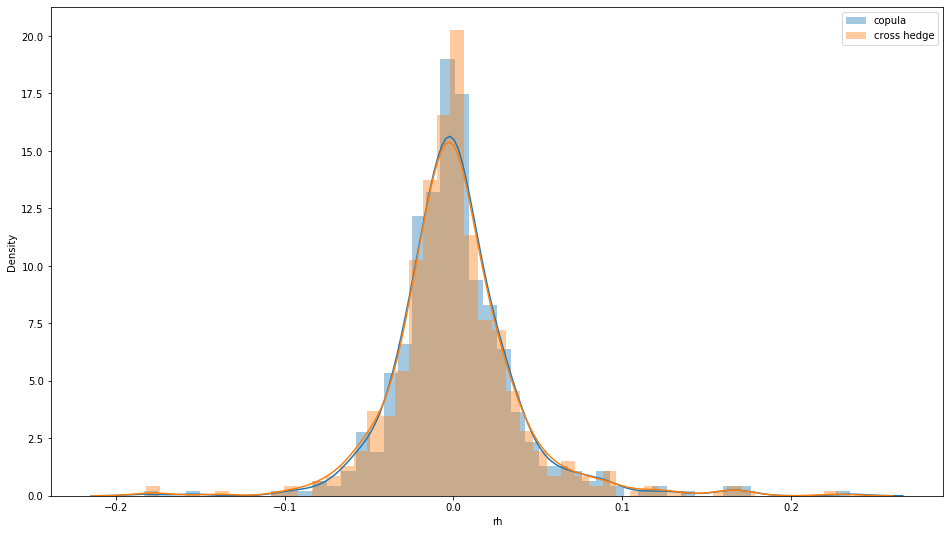

In [549]:
plt.figure(figsize=(16,9))

# sns.distplot(rh_df.new_rh)
sns.distplot(rh_df.rh, label='copula')
sns.distplot(CH.rh, label='cross hedge')
plt.legend()
print('avg h', '\ncopula     :%.3f'%np.mean(rh_df.h),  '\ncross hedge:%.3f'%np.mean(CH.h_CH))

In [550]:
def risk_statistics(rh, name):

    ERM = toolbox.ERM_estimate_trapezoidal(10, rh)
    ES1 = toolbox.ES(0.01, rh)
    ES5 = toolbox.ES(0.05, rh)
    VaR1 = toolbox.VaR(0.01, rh)
    VaR5 = toolbox.VaR(0.05, rh)
    Var = toolbox.Variance(rh)
    
    _dict = {'ERM':ERM, 'ES1':ES1, 'ES5':ES5, 'VaR1':VaR1, 
             'VaR5':VaR5, 'Var':Var}
    
    return pd.DataFrame([_dict], [name])


# Table 1a: Moments, dependency with future, start and end
def summary_statistics(rs, name):
    
    m1 = np.mean(rs)
    m2 = np.std(rs)
    m3 = ss.skew(rs) # Pearson coefficient of skewness
    m4 = ss.kurtosis(rs) # Pearson coefficient of kurtosis

    _max = np.max(rs)
    _min = np.min(rs)

    
    _dict = {'m1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 
            'max':_max, 'min':_min}
    
    return pd.DataFrame([_dict], [name])

In [551]:
print('Summary Statistics', coin_name, objective)
summary_statistics(rh_df.rh, 'copula')\
    .append(summary_statistics(CH.rh, 'cross hedge'))\
    .append(summary_statistics(rh_df.rs, 'spot'))

Summary Statistics eth VaR q=0.01


,m1,m2,m3,m4,max,min
copula,0.001444,0.036613,1.055778,7.244267,0.235111,-0.183561
cross hedge,0.000813,0.037976,0.801399,6.446427,0.227673,-0.182093
spot,0.005437,0.058706,-0.324921,4.800456,0.315242,-0.320144


In [552]:
print('Summary Statistics', coin_name, objective)
summary_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
    .append(summary_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))\
    .append(summary_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))

Summary Statistics eth VaR q=0.01


,m1,m2,m3,m4,max,min
copula in stress period,-0.001918,0.044963,0.176561,4.626810,0.172787,-0.183561
cross hedge in stress period,-0.001979,0.046380,0.090828,4.411544,0.169239,-0.182093
spot in stress period,-0.000102,0.069752,-0.480552,1.925811,0.197551,-0.269777


In [566]:
print(coin_name, objective)
copula_vs_crosshedge = risk_statistics(rh_df.rh, 'copula')\
    .append(risk_statistics(CH.rh, 'cross hedge'))
    
diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge.iloc[0,:]-copula_vs_crosshedge.iloc[1,:])/copula_vs_crosshedge.iloc[1,:]}).T
copula_vs_crosshedge = copula_vs_crosshedge.append(diff).append(risk_statistics(rh_df.rs, 'spot'))
copula_vs_crosshedge


bitcoin ERM k=10


,ERM,ES1,ES5,VaR1,VaR5,Var
copula,0.005824,0.017070,0.010228,0.011756,0.006211,0.000016
cross hedge,0.005621,0.016612,0.009939,0.010840,0.006017,0.000015
% relative diff,3.614733,2.755398,2.908584,8.448265,3.228770,5.841020
spot,0.066608,0.190451,0.115618,0.136746,0.063220,0.002197


In [568]:
print(coin_name, objective)
copula_vs_crosshedge_stressperiod = risk_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
    .append(risk_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))

diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge_stressperiod.iloc[0,:]-copula_vs_crosshedge_stressperiod.iloc[1,:])/copula_vs_crosshedge_stressperiod.iloc[1,:]}).T
copula_vs_crosshedge_stressperiod = copula_vs_crosshedge_stressperiod.append(diff).append(risk_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))
list(copula_vs_crosshedge.columns)

bitcoin ERM k=10


['ERM', 'ES1', 'ES5', 'VaR1', 'VaR5', 'Var']

In [606]:
rm_arr =  [ 'ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05', 'Variance']
# results = {}

for i in range(len(result_names)):
    data_name = result_names[i]
    coin_name = coin_names[i]
    CH = create_CH(data_name, coin_name)

    _index = ['copula', 'cross hedge', '% relative diff', 'spot']
    _index_stress = ['copula in stress period',
             'cross hedge in stress period',
             '% relative diff',
             'spot in stress period']
    columns = ['ERM', 'ES1', 'ES5', 'VaR1', 'VaR5', 'Var']
    copula_vs_crosshedge_result = pd.DataFrame(index=_index, columns=columns)
    copula_vs_crosshedge_stressperiod_result = pd.DataFrame(index=_index_stress, columns=columns)

    for j, objective in enumerate(rm_arr):
        rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, objective))
#         print(data_name, coin_name, objective)
        
        copula_vs_crosshedge = risk_statistics(rh_df.rh, 'copula')\
        .append(risk_statistics(CH.rh, 'cross hedge'))
    
        diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge.iloc[0,:]-copula_vs_crosshedge.iloc[1,:])/copula_vs_crosshedge.iloc[1,:]}).T
        copula_vs_crosshedge = copula_vs_crosshedge.append(diff).append(risk_statistics(rh_df.rs, 'spot'))
        copula_vs_crosshedge_result.iloc[:,j] = copula_vs_crosshedge.iloc[:,j]
        
        
        copula_vs_crosshedge_stressperiod = risk_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
        .append(risk_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))

        diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge_stressperiod.iloc[0,:]-copula_vs_crosshedge_stressperiod.iloc[1,:])/copula_vs_crosshedge_stressperiod.iloc[1,:]}).T
        copula_vs_crosshedge_stressperiod = copula_vs_crosshedge_stressperiod.append(diff).append(risk_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))
        copula_vs_crosshedge_stressperiod_result.iloc[:,j] = copula_vs_crosshedge_stressperiod.iloc[:,j]

    copula_vs_crosshedge_result.to_csv('../../results/%s/MM/copula_vs_crosshedge.csv'%data_name)
    copula_vs_crosshedge_stressperiod_result.to_csv('../../results/%s/MM/copula_vs_crosshedge_stressperiod.csv'%data_name)

In [615]:
i = 3
data_name = result_names[i]
print(coin_names[i])
r = pd.read_csv('../../results/%s/MM/copula_vs_crosshedge.csv'%data_name).append(pd.read_csv('../../results/%s/MM/copula_vs_crosshedge_stressperiod.csv'%data_name))
r.index = list(r.iloc[:,0])
r = r.iloc[:,1:]
r

ltc


,ERM,ES1,ES5,VaR1,VaR5,Var
copula,0.058828,0.149425,0.092922,0.094752,0.063848,0.001755
cross hedge,0.062266,0.167335,0.097900,0.110785,0.062293,0.001813
% relative diff,-5.521211,-10.703020,-5.085515,-14.472352,2.497494,-3.216869
spot,0.096164,0.261008,0.163300,0.187398,0.095560,0.004076
copula in stress period,0.067627,0.205845,0.116784,0.113548,0.076603,0.002621
cross hedge in stress period,0.068253,0.197203,0.117779,0.117185,0.070380,0.002617
% relative diff,-0.917372,4.382310,-0.845265,-3.103126,8.841549,0.174381
spot in stress period,0.113052,0.281010,0.194193,0.185661,0.139036,0.005688
